# Logistic Regression

For this lecture we will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic).

We'll be trying to predict a classification- survival or deceased.

## Import Libraries


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [78]:
train = pd.read_csv('titanic_train.csv')

In [79]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

Let's start by checking for missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

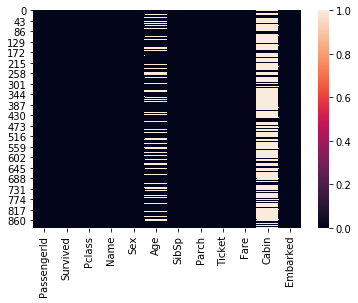

In [80]:
sns.heatmap(train.isnull())

Roughly 20 percent of the Age data is missing, likely small enough for reasonable replacement with some form of imputation. Cabin, instead, is missing too many values.

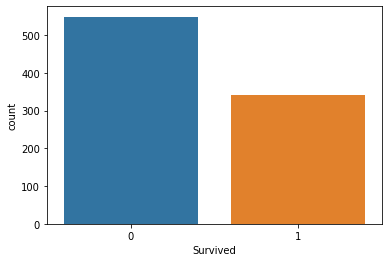

In [81]:
sns.countplot(x='Survived', data=train)

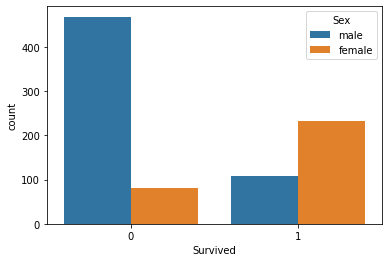

In [82]:
sns.countplot(x='Survived', hue='Sex', data=train)

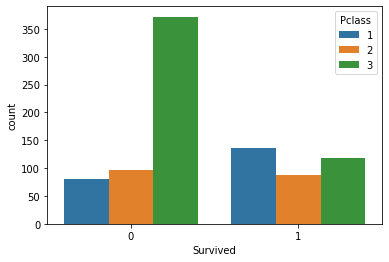

In [83]:
sns.countplot(x='Survived', hue='Pclass', data=train)

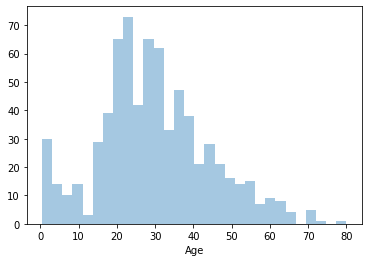

In [84]:
sns.distplot(train['Age'].dropna(), kde=False, bins=30)

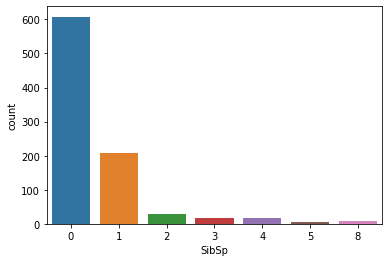

In [85]:
sns.countplot(x='SibSp', data=train)

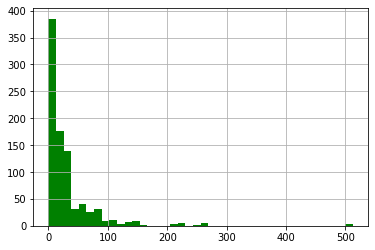

In [86]:
train['Fare'].hist(color='green', bins=40)

___
## Data Cleaning

We want to fill in missing age data instead of just dropping the missing age data rows. We can fill in the mean, or even the average age by class.

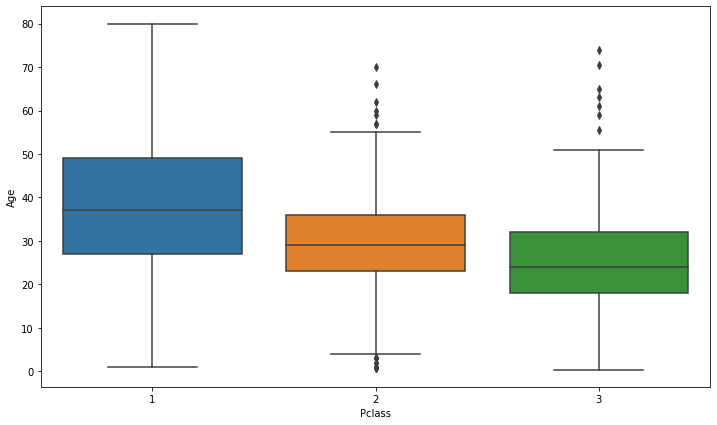

In [87]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass', y='Age', data=train)

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [88]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

In [89]:
train['Age'] = train[['Age','Pclass']].apply(impute_age, axis=1)

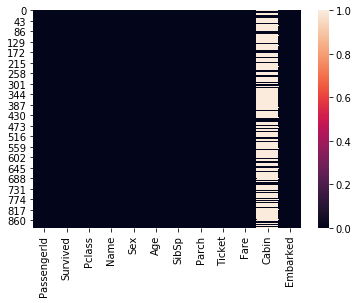

In [90]:
sns.heatmap(train.isnull())

Let's drop the Cabin column and any other row with NaN.

In [91]:
train.drop('Cabin', axis=1, inplace=True)

In [92]:
train.dropna(inplace=True)

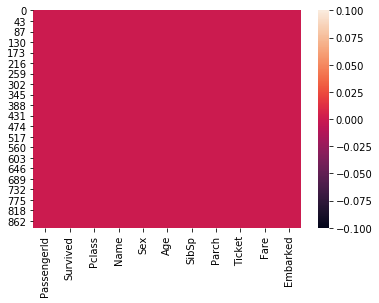

In [93]:
sns.heatmap(train.isnull())

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas.

In [94]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [95]:
pd.get_dummies(train['Sex'], drop_first=True)

,male
0,1
1,0
2,0
3,0
4,1
...,...
886,1
887,0
888,0
889,1


In [97]:
sex = pd.get_dummies(train['Sex'], drop_first=True)
embark = pd.get_dummies(train['Embarked'], drop_first=True)

In [98]:
train.drop(['Sex','Embarked','Name','Ticket'], axis=1, inplace=True)

In [99]:
train = pd.concat([train, sex, embark], axis=1)

In [100]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


In [106]:
train.drop('PassengerId', axis=1, inplace=True)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


# Building a Logistic Regression model

## Train Test Split

In [107]:
from sklearn.model_selection import train_test_split

In [108]:
X = train.drop('Survived', axis=1)
y = train['Survived']

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30, 
                                                    random_state=101)

## Training and Predicting

In [110]:
from sklearn.linear_model import LogisticRegression

In [114]:
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [115]:
predictions = logmodel.predict(X_test)

## Evaluation

In [116]:
from sklearn.metrics import classification_report

In [117]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       163
           1       0.85      0.69      0.76       104

    accuracy                           0.83       267
   macro avg       0.84      0.81      0.82       267
weighted avg       0.83      0.83      0.83       267



In [118]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[150,  13],
       [ 32,  72]])

You might want to explore other feature:

* Try grabbing the Title (Dr.,Mr.,Mrs,etc..) from the name as a feature
* Maybe the Cabin letter could be a feature
* Is there any info you can get from the ticket?